# Notebook for ZFOURGE CDFS Luminosity (Magnitude) Functions Following the SDSS Example

### Import and setup

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

n_lum_bins = 30 # number of luminosity bins
mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
all_mag_bins = [30, 25, 25, 20, 15, 10] # number of absolute magnitude bins in each redshift bin

### Ks Band Distributions

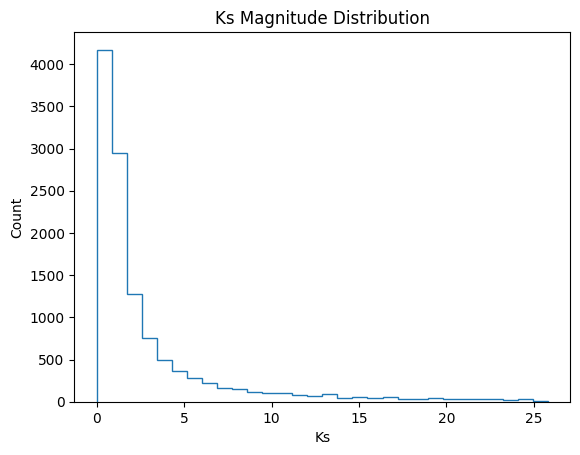

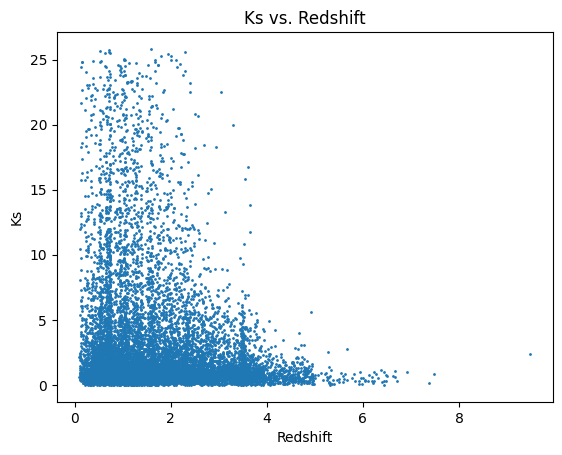

In [35]:
z = df['zpk'] # redshift
mag_app = df['FKs'] # apparent Ks magnitude
mask = (df['FKs'] <= mag_lim)

plt.hist(mag_app[mask], bins=n_lum_bins, histtype='step')
plt.title('Ks Magnitude Distribution')
plt.xlabel('Ks')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_app[mask], s=1)
plt.title('Ks vs. Redshift')
plt.xlabel('Redshift')
plt.ylabel('Ks')
plt.show()

### AB Magnitude Distributions

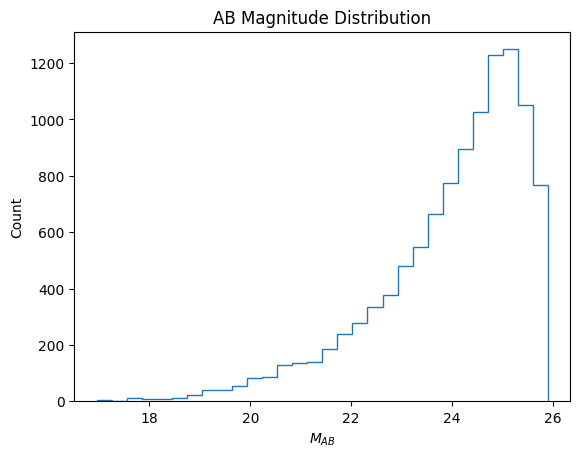

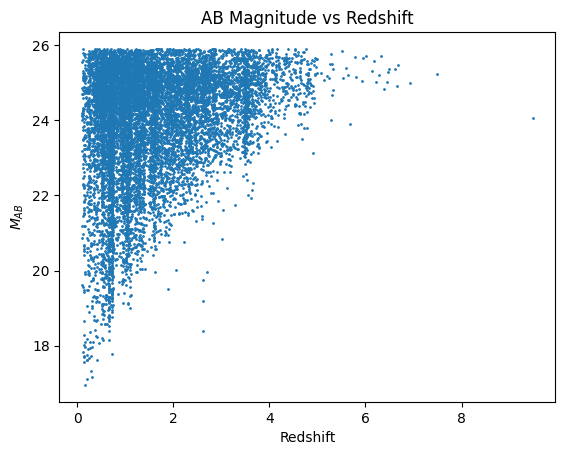

In [36]:
mag_ab = 25 - 2.5*np.log10(mag_app) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)

plt.title('AB Magnitude Distribution')
plt.hist(mag_ab[mask], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_ab[mask], s=1)
plt.title('AB Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('$M_{AB}$')
plt.show()

### Absolute Magnitude Distributions

This shows the difference in using `luminosity_distance` vs `comoving_distance` to calculate the absolute magnitude. The `luminosity_distance` is the correct method of calculating the absolute magnitudes.

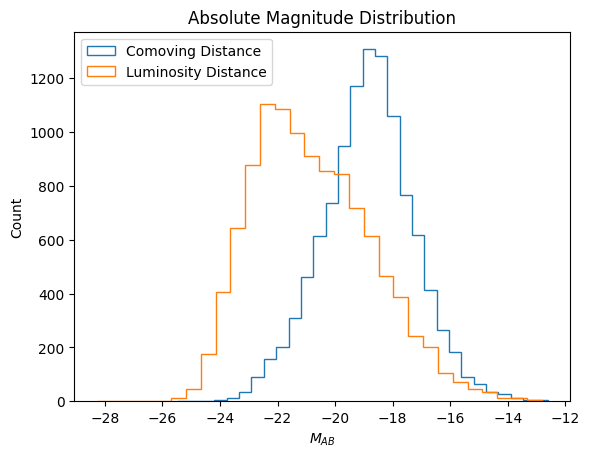

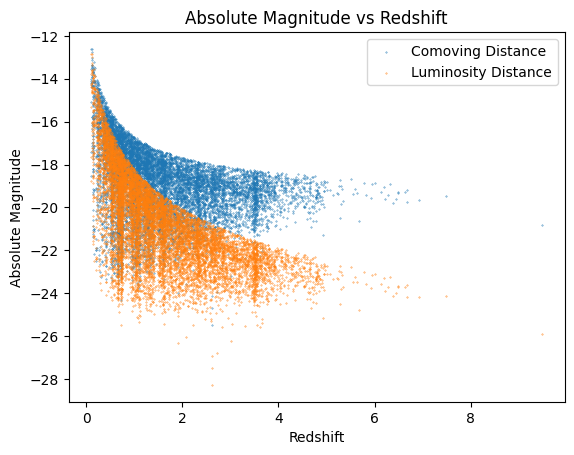

In [37]:
# Cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Absolute Magnitude from luminosity distance
dists = cosmo.luminosity_distance(z) # Mpc
dists *= 10 ** 6 # Mpc -> pc
Mag_abs = mag_ab - 5 * np.log10(dists / 10) # AB magnitude -> absolute magnitude

# Absolute Magnitude from comoving distance
dists_cm = cosmo.comoving_distance(z).value # Mpc
dists_cm *= 10 ** 6 # Mpc -> pc
Mag_abs_cm = mag_ab - 5 * np.log10(dists_cm / 10) # AB magnitude -> absolute magnitude

mask = (mag_ab <= mag_lim) 

plt.title('Absolute Magnitude Distribution')
plt.hist(Mag_abs_cm[mask], bins=n_lum_bins, histtype='step', label='Comoving Distance')
plt.hist(Mag_abs[mask], bins=n_lum_bins, histtype='step', label='Luminosity Distance')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.scatter(z[mask], Mag_abs_cm[mask], s=0.1, label='Comoving Distance')
plt.scatter(z[mask], Mag_abs[mask], s=0.1, label='Luminosity Distance')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

### Absolute Magnitude Limit vs Redshift

This shows the `luminosity_distance` and `comoving_distance` limits against the absolute magnitude. Notice the magnitudes follow the `luminosity_distance`.

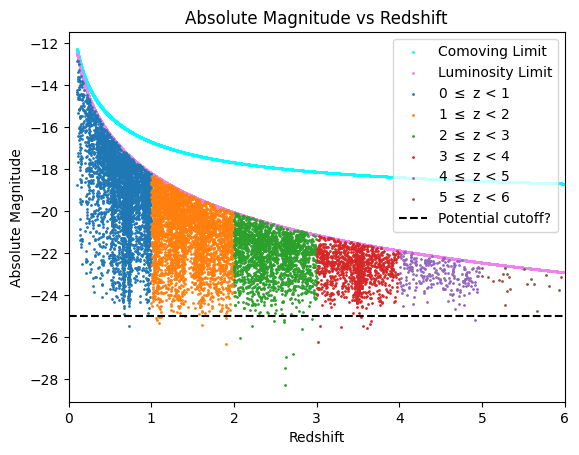

In [38]:
# Masking magnitude (mag_ab <= mag_lim)
z = z[mask]

# Luminoisty distance absolute magnitude
Mag_abs = Mag_abs[mask]
dists = dists[mask]

# Comoving distance absolute magnitude
Mag_abs_cm = Mag_abs_cm[mask]
dists_cm = dists_cm[mask]

# Magnitude limits
z_range = np.linspace(z.min(), z.max(), 10000)
M_lim = mag_lim - 5 * np.log10(cosmo.luminosity_distance(z_range).to('pc').value / 10) # luminosity absolute magnitude limit
M_lim_cm = mag_lim - 5 * np.log10(cosmo.comoving_distance(z_range).to('pc').value / 10) # comoving absolute magnitude limit

# Plot
plt.scatter(z_range, M_lim_cm, s=1, label='Comoving Limit', color='cyan')
plt.scatter(z_range, M_lim, s=1, label='Luminosity Limit', color='violet')
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    plt.scatter(z[mask], Mag_abs[mask], s=1, label=f'{z_min} $\leq$ z < {z_max}')
plt.axhline(y=-25, color='black', linestyle='--', label='Potential cutoff?')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.xlim(0, 6)
plt.show()

### Absolute Magnitude Bin Limits vs Maximum Redshift

This shows that when calculating the maximum possible distance, to eventually calculate volume, the absolute magnitudes no longer follow the `luminosity_distance` limit and instead follow the `comoving_distance` limit. This must be corrected by excluding sources above the `luminosity_distance` limit.

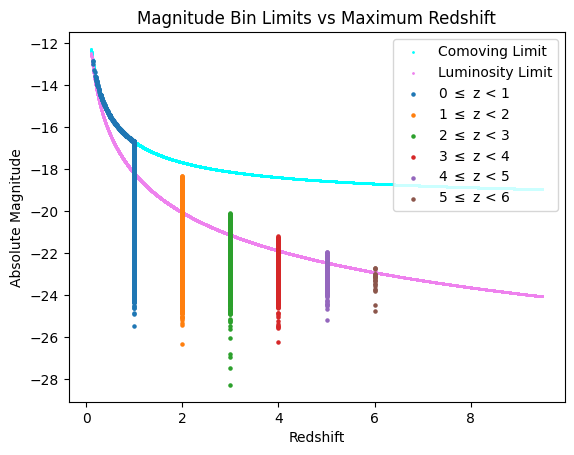

In [39]:
plt.scatter(z_range, M_lim_cm, s=1, label='Comoving Limit', color='cyan')
plt.scatter(z_range, M_lim, s=1, label='Luminosity Limit', color='violet')
for (z_min, z_max), mag_abs_bins in zip(redshift_bins, all_mag_bins):
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - Mag_abs_bin) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    Mag_abs_bin = Mag_abs_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lim = z_at_value(cosmo.comoving_distance, dmaxs.values * u.Mpc)
    plt.scatter(z_lim, Mag_abs_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Magnitude Bin Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend(loc='upper right')
plt.show()

### Calculate and save binned counts, volumes, magnitudes, & data

Removing sources which do not follow the `luminosity_distance` limit

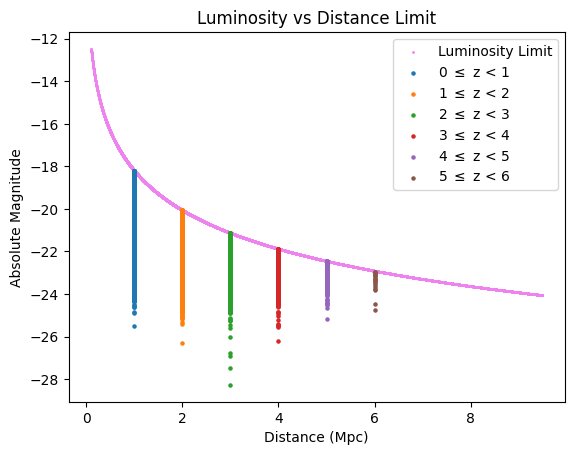

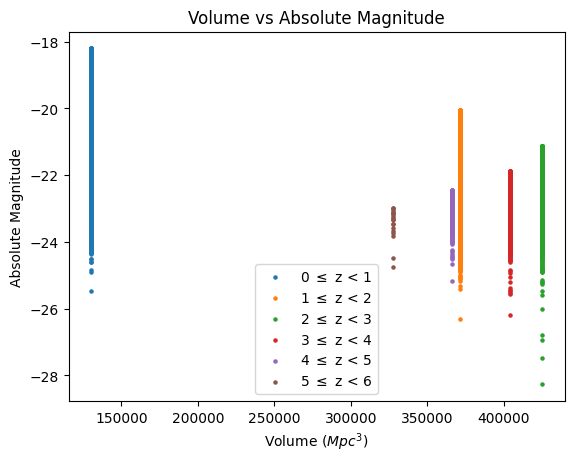

In [40]:
def M_abs_lim(z):
    """ Luminosity distance absolute magnitude limit as a function of redshift """
    return mag_lim - 5 * np.log10(cosmo.luminosity_distance(z).to('pc').value / 10)

all_data = []

plt.scatter(z_range, M_lim, s=1, label='Luminosity Limit', color='violet')
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs[mask]
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - Mag_abs_bin) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be less than or equal to the maximum absolute magnitude (from luminosity distance)
    m = M_abs_lim(z_max)
    mlim_mask = Mag_abs_bin <= m
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    mag = Mag_abs_bin[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, mag])

    z_lim = z_at_value(cosmo.comoving_distance, dmaxs.values * u.Mpc)
    plt.scatter(z_lim, mag, s=5, label=f'{z_min} $\leq$ z < {z_max}')    

plt.title('Luminosity vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Absolute Magnitude')
plt.legend(loc='upper right')
plt.show()

plt.title('Volume vs Absolute Magnitude')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

### Counts Histograms

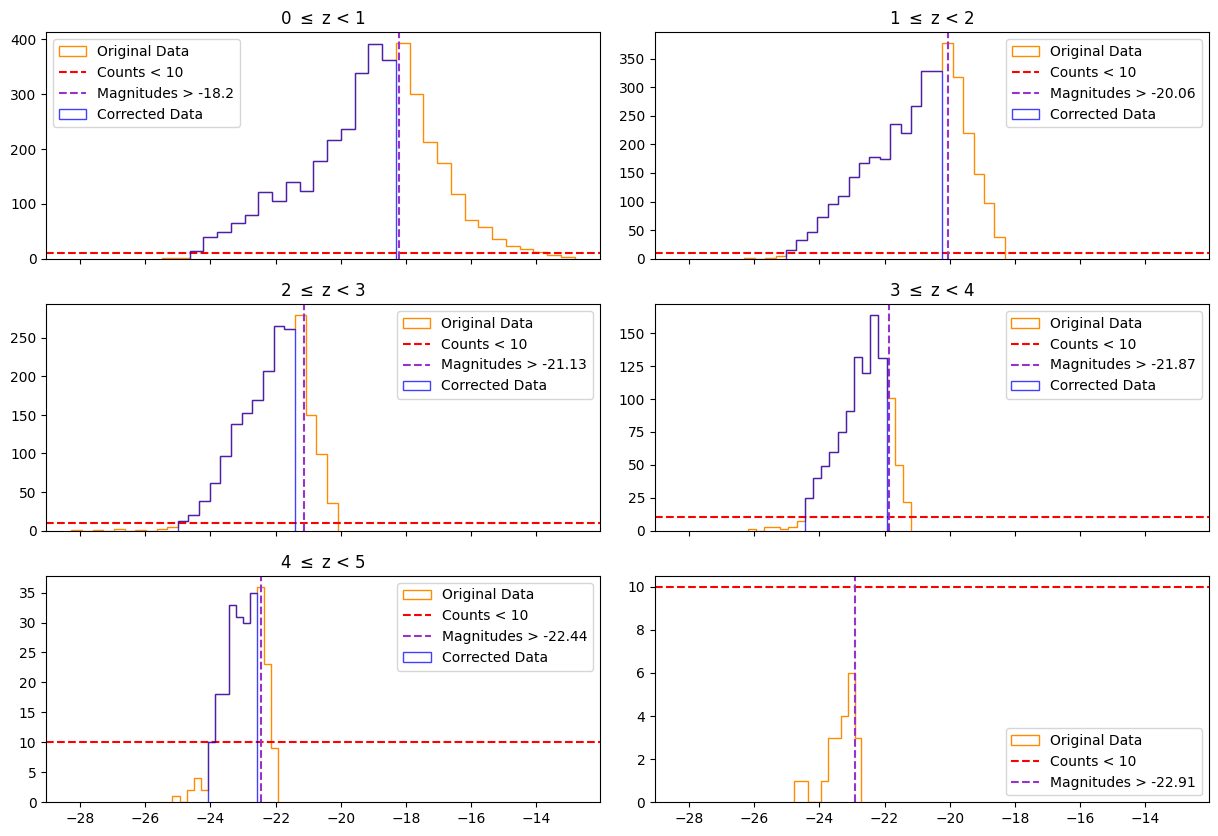

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, mag), bins, ax in zip(redshift_bins, all_data, all_mag_bins, axes.flatten()):
    
    # Bin the original data
    _, b, _ = ax.hist(Mag_abs[(z >= z_start) & (z < z_end)], bins=bins, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(mag, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    b = b[:-1][c_mask]
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(M_abs_lim(z_end), color='darkorchid', linestyle='--', label=f'Magnitudes > {round(M_abs_lim(z_end), 2)}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.75)
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    ax.legend()
    bin_edges.append(b)
    
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

### Luminosity Function

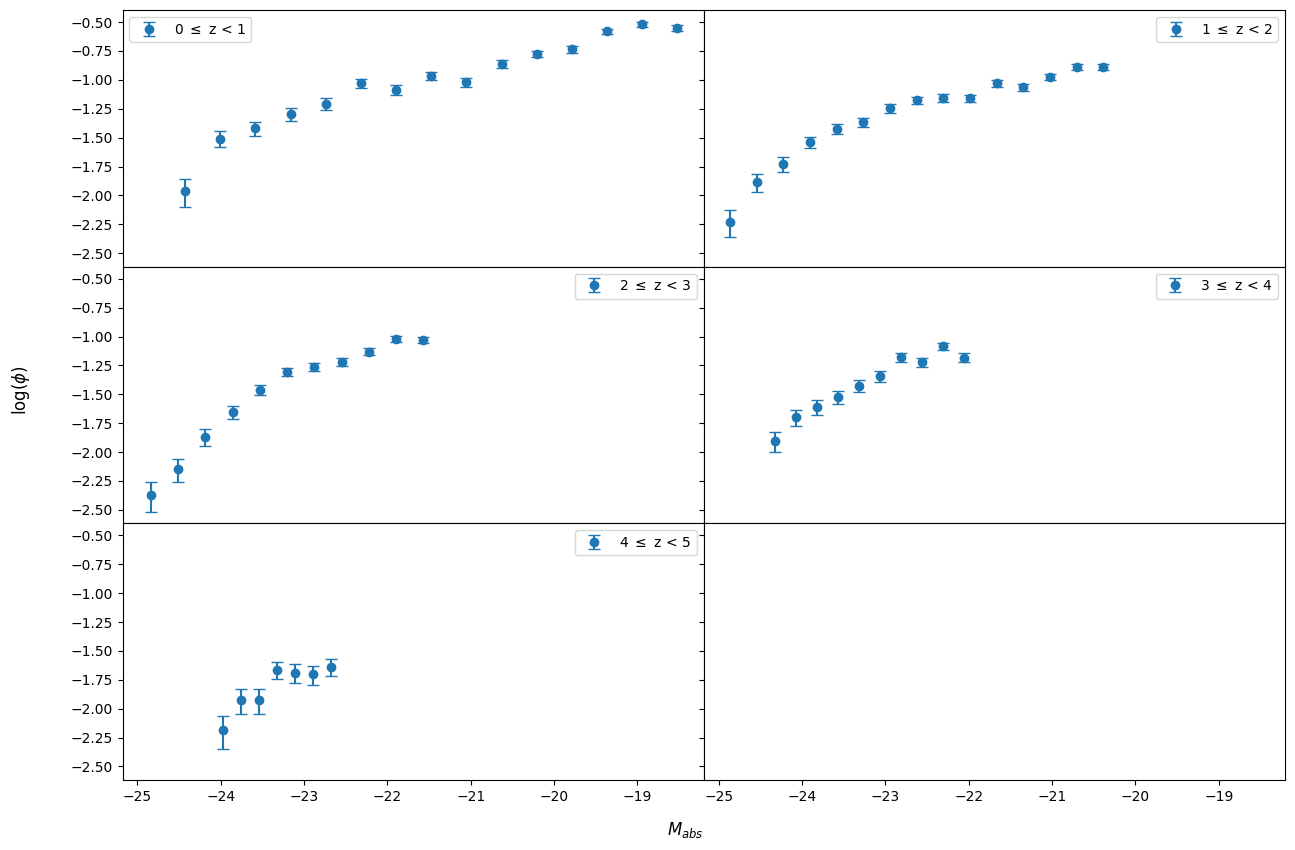

In [42]:
lum_centers, phi, phi_e = [], [], []

# Volume and magnitude are already binned by redshift
for (vol, mag), bin, in zip(all_data, bin_edges):
    
    delta_log_l = np.diff(np.log10(np.abs(bin[::-1])))[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (mag >= lum_start) & (mag < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
    

### Schechter Fit

C:\Users\n10480129\AppData\Local\Temp\ipykernel_15408\1619295273.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))


0 <= z < 1 Function fit:
M_star = -2.48e+01
phi_star = 3.37e-02
alpha = 1.39e+00


1 <= z < 2 Function fit:
M_star = -2.44e+01
phi_star = 4.49e-02
alpha = 1.30e+00


2 <= z < 3 Function fit:
M_star = -2.37e+01
phi_star = 7.62e-02
alpha = 1.19e+00


3 <= z < 4 Function fit:
M_star = -2.33e+01
phi_star = 1.15e-01
alpha = 8.89e-01


4 <= z < 5 Function fit:
M_star = -2.25e+01
phi_star = 5.71e-02
alpha = -3.37e-01




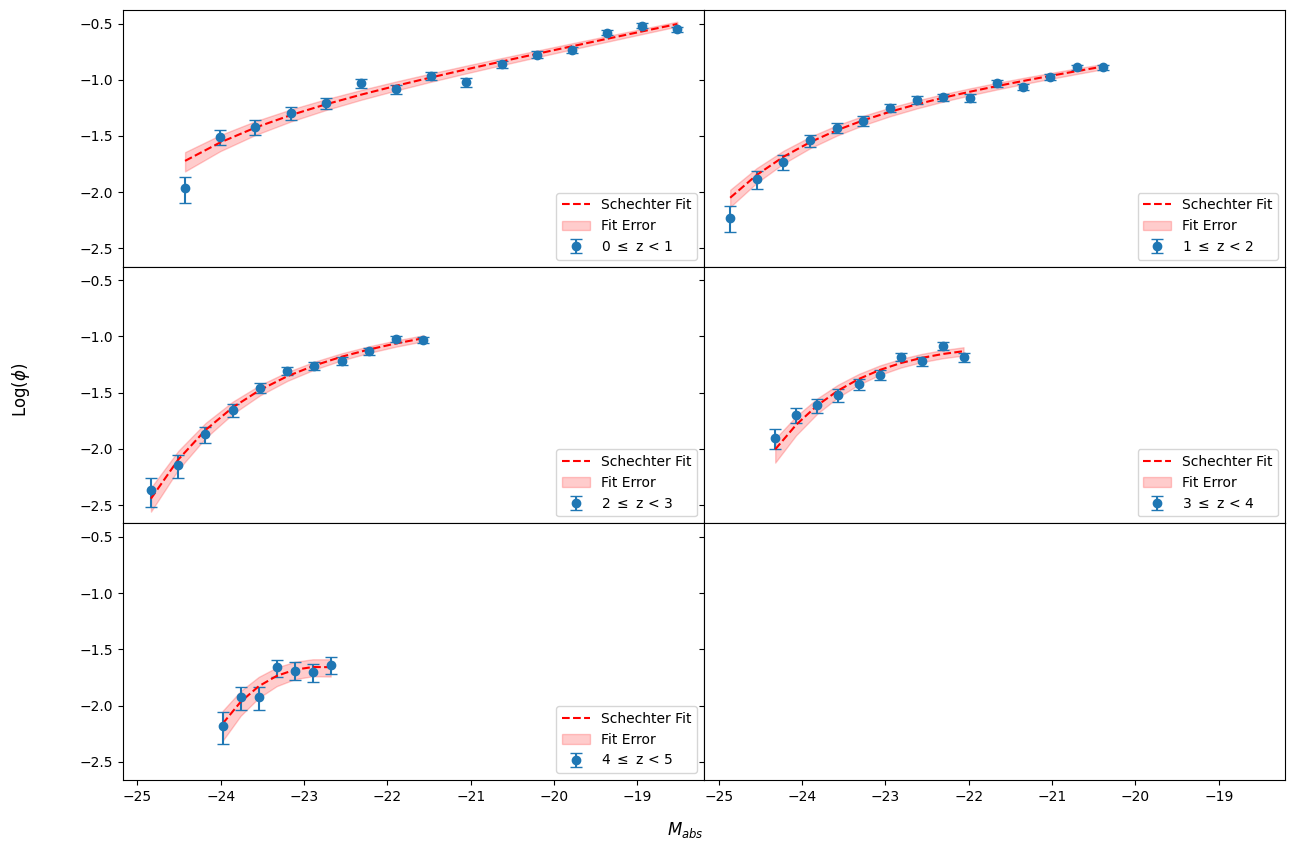

In [43]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(schechter_magnitude(lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(lum, 
        np.log10(schechter_magnitude(lum, *p_down)),
        np.log10(schechter_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error') 
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

C:\Users\n10480129\AppData\Local\Temp\ipykernel_15408\2541604395.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)


0 <= z < 1 Function fit:
M_star = -3.41e+01
phi_star = 9.86e-04
alpha = 1.40e+00
sigma = 4.51e-05


1 <= z < 2 Function fit:
M_star = -7.73e+00
phi_star = 1.02e-04
alpha = -4.65e-01
sigma = 1.14e+00


2 <= z < 3 Function fit:
M_star = -2.43e+01
phi_star = 4.09e-02
alpha = 1.36e+00
sigma = 1.95e-01


3 <= z < 4 Function fit:
M_star = -1.83e+01
phi_star = 4.87e-04
alpha = -1.99e+00
sigma = -4.64e-01


4 <= z < 5 Function fit:
M_star = -2.61e+01
phi_star = 8.57e-02
alpha = 6.32e-01
sigma = 2.93e-02




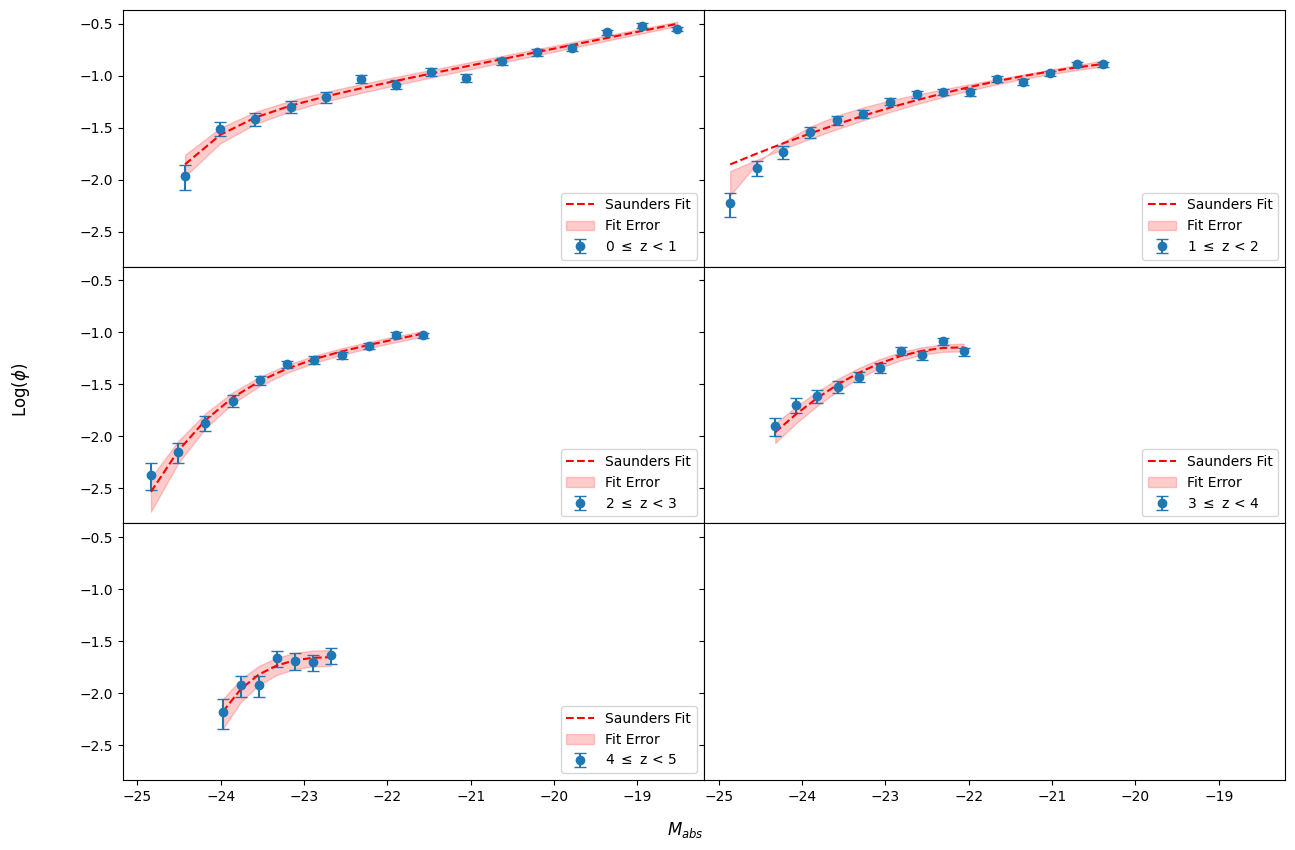

In [44]:
def saunders_magnitude(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0 = [lum[0], 0.001, -0.9, 0.1]
    try:
        params, _ = curve_fit(saunders_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(saunders_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(saunders_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        continue        
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(saunders_magnitude(lum, *params)), color='red', label='Saunders Fit', linestyle='--')   
    ax.fill_between(lum, 
        np.log10(saunders_magnitude(lum, *p_down)), 
        np.log10(saunders_magnitude(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()